[View in Colaboratory](https://colab.research.google.com/github/toanchitran/tensorflow/blob/master/download_and_load_data_from_kaggle.ipynb)

In [1]:
!pip install kaggle

    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 235kB 5.2MB/s 
  Running setup.py bdist_wheel for kaggle ... - done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [0]:
import os
import glob
import zipfile
import functools

In [3]:
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
    try:
      with open(token_file, 'r') as f:
        pass
    except IOError as no_file:
      try:
        from google.colab import files
      except ImportError:
        raise no_file
        
      uploaded = files.upload()
      
      if "kaggle.json" not in uploaded:
        raise ValueError("You need an Kaggle API key. Get one at  "
                        "https://github.com/Kaggle/kaggle-api#api-credentials")
      with open(token_file, "wb") as f:
        f.write(uploaded["kaggle.json"])
        
      os.chmod(token_file, 600)
        
get_kaggle_credentials()

Saving kaggle.json to kaggle.json


In [0]:
import kaggle

In [0]:
competition_name = 'carvana-image-masking-challenge'

In [0]:
def load_data_from_zip(competition, file):
  with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
    unzipped_file = zip_ref.namelist()[0]
    zip_ref.extractall(competition)

def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    load_data_from_zip(competition, 'train.zip')
    load_data_from_zip(competition, 'train_masks.zip')
    load_data_from_zip(competition, 'train_masks.csv.zip')

In [0]:
get_data(competition_name)

In [0]:
img_dir = os.path.join(competition_name, "train")
label_dir =  os.path.join(competition_name, "train_masks")

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image



import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K



In [0]:
df_train = pd.read_csv(os.path.join(competition_name, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [0]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
  x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [0]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state = 42)

In [16]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 4070
Number of validation examples: 1018


In [17]:
x_train_filenames[:10]

['carvana-image-masking-challenge/train/69915dab0755_16.jpg',
 'carvana-image-masking-challenge/train/695f39dfac16_04.jpg',
 'carvana-image-masking-challenge/train/2267f4aa0d2c_13.jpg',
 'carvana-image-masking-challenge/train/562706000bd7_15.jpg',
 'carvana-image-masking-challenge/train/917f262f1608_06.jpg',
 'carvana-image-masking-challenge/train/fce0ba5b8ed7_07.jpg',
 'carvana-image-masking-challenge/train/93881caf9f70_10.jpg',
 'carvana-image-masking-challenge/train/eb07e3f63ad2_09.jpg',
 'carvana-image-masking-challenge/train/78bfb9c780db_10.jpg',
 'carvana-image-masking-challenge/train/d3d0d2662918_12.jpg']

In [18]:
y_train_filenames[:10]

['carvana-image-masking-challenge/train_masks/69915dab0755_16_mask.gif',
 'carvana-image-masking-challenge/train_masks/695f39dfac16_04_mask.gif',
 'carvana-image-masking-challenge/train_masks/2267f4aa0d2c_13_mask.gif',
 'carvana-image-masking-challenge/train_masks/562706000bd7_15_mask.gif',
 'carvana-image-masking-challenge/train_masks/917f262f1608_06_mask.gif',
 'carvana-image-masking-challenge/train_masks/fce0ba5b8ed7_07_mask.gif',
 'carvana-image-masking-challenge/train_masks/93881caf9f70_10_mask.gif',
 'carvana-image-masking-challenge/train_masks/eb07e3f63ad2_09_mask.gif',
 'carvana-image-masking-challenge/train_masks/78bfb9c780db_10_mask.gif',
 'carvana-image-masking-challenge/train_masks/d3d0d2662918_12_mask.gif']

##Visualize

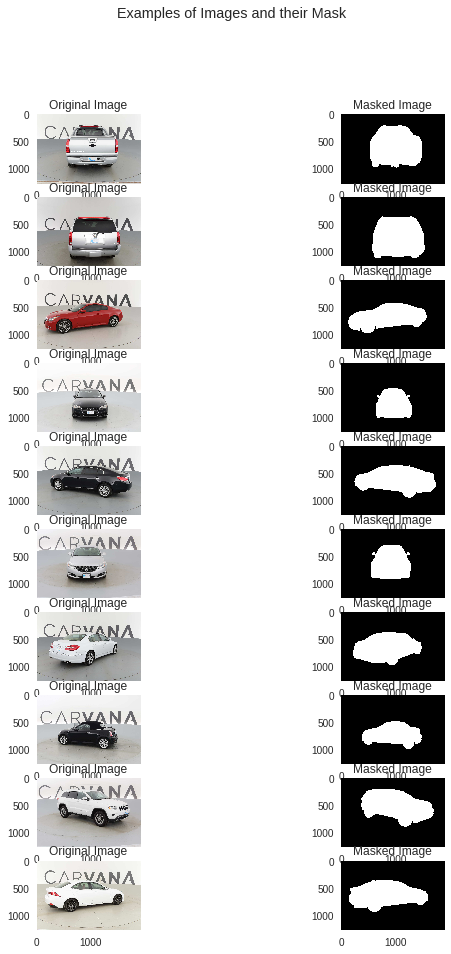

In [21]:
display_num = 10

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10,15))

for i in range(0, display_num*2, 2):
  img_num = r_choices[i//2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i+1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(example_labels)
  
  plt.subplot(display_num, 2, i+2)
  plt.imshow(example_labels)
  plt.title("Masked Image")
  
plt.suptitle("Examples of Images and their Mask")
plt.show()